# Physics-informed DeepONet: Solving a ODE for different right hand sides
In this notebook, we present an introduction to the physics-informed DeepONet [(paper)](https://arxiv.org/abs/2103.10974) utilities of TorchPhysics.
As an example, we try to learn the integral operator of the ODE:
\begin{align*}
    \partial_t u(t) &= f(t), \text{ in } [0, 1] \\
    u(0) &= 0
\end{align*}
for different functions $f$. Before describing the implementation in TorchPhysics we give a short recall of DeepONets.


# Recall of Deep Operator Networks (DeepONets)

We wish to learn the solution $u_f:[0,1]\to \mathbb{R}$ for many different choices of functions $f:[0,1]\to \mathbb{R}$ by a DeepONet $\varphi_{\theta}.$
The construction of DeepOnets is described in what follows:

1) The basic idea is to represent $u_f$ as a linear combination of neural networks $\varphi_i:[0,1]\to \mathbb{R}$
$$
u_f(t) \approx \sum_{i=1}^n c_i(f) \varphi_i(t),
$$
where the coefficients $c_i(f)$ depend on the parameter function $f$ that leads to the solution $u_f$ of the ODE above.

2) We would wish to replace $c_i(f)$ by a neural network, too. However, we cannot use a function $f$ as an input of a neural network. Instead, we collect finitely many information about $f$ by sampling $f$ at sampling points $t_1, ..., t_k$. These serve as inputs of neural networks $\psi_i$ for approximating the coefficients
$$
c_i(f) \approx \psi_i( f(t_1), ..., f(t_k) ).
$$

3) A DeepONet $\varphi_\theta$ is hence defined as
$$
\varphi_\theta(f,t) := \sum_{i=1}^n \psi_i( f(t_1),...,f(t_k) ) \varphi_i(t) ≈u_f(t).
$$
Typically, all $\psi_i$ are collected within a single neural network, the so-called branch net $\varphi_{branch}:[0,1] \to \mathbb{R}^n$, whose output coordinates just represent the $\psi_i$. Similarly, the $\varphi_i$ are represented by a so-called trunk net $\varphi_{trunk}:[0,1] \to \mathbb{R}^n$.
So the branch net receives only information about the parameter function $f$, whereas the input of the trunk net is the coordinate $t$ at which the solution $u_f$ is to be approximated.
Note that the sampling points $t_1, ..., t_k$ needs to be fixed beforehang and should not be changed for different $f$, simply to not confuse the branch net $\varphi_{branch}$.

# Physics-informed DeepONets in TorchPhysics

The general structure of TorchPhysics still holds for DeepONet problems, so we can follow the same step-by-step recipe as in the [PINN-tutorials](https://torchphysics.de/tutorial).
However, we need some new concepts to define training functions of $f$. Here we show, how to:

- create a function space for different training functions
- define a DeepONet-neural-network consisting of trunk and branch net

and some additional details one has to consider.

In [2]:
import os
import torch
import torchphysics as tp
import pytorch_lightning as pl

## Step 1: Specify spaces and domains
As in the PINN tutorials we need to specify the input and output spaces of the solution functions $u_f:[0,1]\to \mathbb{R}$.

In [3]:
# Input and output spaces
T = tp.spaces.R1('t') # input variable
U = tp.spaces.R1('u') # output variable

# Domain of u_f
T_int = tp.domains.Interval(T, 0, 1)

The DeepONet tries to learn many different $u_f$ for parameter functions $f$. Therefore, we need to define a set of functions $f$ that will be used for training the DeepONet.
We consider the function set that consist of the following parameterized functions for $k\in [0,6]$
$$
f_1(t, k) = kt,\\
f_2(t, k) = kt^2,\\
f_3(t, k) = k\cos(kt).
$$

In [4]:
def f1(k, t):
    return k*t
def f2(k, t):
    return k*t**2
def f3(k, t):
    return k*torch.cos(k*t)

In order to construct this function set in TorchPhysics, we need to create input and output spaces for these functions $f_i$, similar to what we did with $u_f$. Here, also the parameter $k$ is treated as an input. Note that for the input variable $t$ we do not specify a space and domain again, as we already did that above.

In [5]:
# Input and output spaces for the parameterized functions f_1, f_2, f_3
K = tp.spaces.R1('k') # Parameter
F = tp.spaces.R1('f') # Function output space name
# Domains
K_int = tp.domains.Interval(K, 0, 6) # Parameters will be scalar values

If different ranges for $k$ were to be used for different $f_i$, one would have needed to create multiple parameter spaces and domains.

The function set of all $f_i$ for all $k\in [0,6]$ is considered as a domain object in TorchPhysics, simply because this set serves as the input for the branch net of the DeepONet. The constructor of CustomFunctionSet(...) receives three inputs:
- A function space that specifies the domain and output space of the functions $f_i:[0,1] \to \mathbb{R}$;
- A sampler for providing different parameters $k$;
- The parameterized function $f_i$ that represents the function set.

We first create function sets for all $f_i$ individually and afterwards obtain the union by the "+" operator.

In [6]:
# Defining function set
Fn_space = tp.spaces.FunctionSpace(T_int, F)

param_sampler = tp.samplers.RandomUniformSampler(K_int, n_points=40)

Fn_set_1 = tp.domains.CustomFunctionSet(Fn_space, param_sampler, f1)
Fn_set_2 = tp.domains.CustomFunctionSet(Fn_space, param_sampler, f2)
Fn_set_3 = tp.domains.CustomFunctionSet(Fn_space, param_sampler, f3)

Fn_set = Fn_set_1 + Fn_set_2 + Fn_set_3 # "+" computes the union of function sets

Mathematically, Fn_set represents the function set
$$
\{ f_i(\cdot , k): \text{for } i=1,2,3 \text{ and } k\in [0,6] \}.
$$

## Step 2: Define point samplers
As in the PINN tutorials we need to define samplers for the ODE condtion and the initial condition.

In [7]:
sampler_ode_condition = tp.samplers.RandomUniformSampler(T_int, 1000)

sampler_initial_condition = tp.samplers.RandomUniformSampler(T_int.boundary_left, 500)

## Step 3: Define residual functions
Similar to $u$, the parameter function $f$ occuring in the ODE condition will already have been sampled when the residual functions are called. Therefore, we define the residual functions as:

In [8]:
def residual_ode_condition(u, t, f):
    return tp.utils.grad(u, t) - f

def residual_initial_condition(u):
    return u


## Step 4: Define DeepONet

The branch net in TorchPhysics needs to know the function space the parameter functions $f$ belong to. Further, it needs to know the points $t_1,.,,,t_k$ at which these $f$ are to be sampled. These sampling points can just be obtained by for example a GridSampler. As mentioned in the recall, these sampling points should be fixed and never changed. Therefore, we need to make this sampler static.

In [9]:
# Branch net
branch_input_sampler = tp.samplers.GridSampler(T_int, 50).make_static() # hence, there will be 50 sampling points $t_j$
# We choose a fully connected network for the branch net, in TorchPhysics: FCBranchNet(...)
branch_net = tp.models.FCBranchNet(Fn_space, hidden=(50, 50), discretization_sampler=branch_input_sampler)

Also for the trunk net we choose a fully connected network.

In [10]:
trunk_net = tp.models.FCTrunkNet(T, hidden=(30, 30))

The constructor of the DeepONet receives just the trunk net, the branch net, the output space of the solution functions $u_f$, as well as the output dimension $n$ of the branch and trunk nets. We set the output dimension to $50$. Having a look at the DeepONet recall again, this means that the DeepONet can represent a function vector space of dimension $\leq 50$.

In [11]:
model = tp.models.DeepONet(trunk_net, branch_net, U, output_neurons=50)

## Step 5: Create TorchPhysics Conditions
Almost done: We only need to define the TorchPhysics conditions for the ODE and initial condition. Since the DeepONet is to be trained physics-informed, we need to define PIDeepONetConditions.

In [12]:
# Conditions for the ODE problem
ode_condition = tp.conditions.PIDeepONetCondition(deeponet_model=model,
                                                  function_set=Fn_set,
                                                  input_sampler=sampler_ode_condition,
                                                  name='ode_condition', # By specifying a name
                                                  residual_fn=residual_ode_condition)

initial_condition = tp.conditions.PIDeepONetCondition(deeponet_model=model,
                                                      function_set=Fn_set,
                                                      input_sampler=sampler_initial_condition,
                                                      residual_fn=residual_initial_condition)

# Training

In [13]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.0005)

solver = tp.solver.Solver([ode_condition, initial_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=3000,
                     logger=False,
                     enable_checkpointing=False)

trainer.fit(solver)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | train_conditions | ModuleList | 10.2 K | train
1 | val_conditions   | ModuleList | 0      | train
--------------------------------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=3000` reached.


If training should be fine-tuned, switch to the LBFGS optimizer.

In [14]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.4,
                            optimizer_args={'max_iter':2, 'history_size': 100})

# here now use grid points for reducing computation time:
ode_condition.input_sampler = tp.samplers.GridSampler(T_int, n_points=4000).make_static()
initial_condition.input_sampler = initial_condition.input_sampler.make_static()
# also fix parameters for input functions:
Fn_set_1.parameter_sampler = Fn_set_1.parameter_sampler.make_static()
Fn_set_2.parameter_sampler = Fn_set_2.parameter_sampler.make_static()
Fn_set_3.parameter_sampler = Fn_set_3.parameter_sampler.make_static()


solver = tp.solver.Solver(train_conditions=[ode_condition, initial_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=2000,
                     logger=False,
                     enable_checkpointing=False)

trainer.fit(solver)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | train_conditions | ModuleList | 10.2 K | train
1 | val_conditions   | ModuleList | 0      | train
--------------------------------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2000` reached.


# Comparison with ground truth

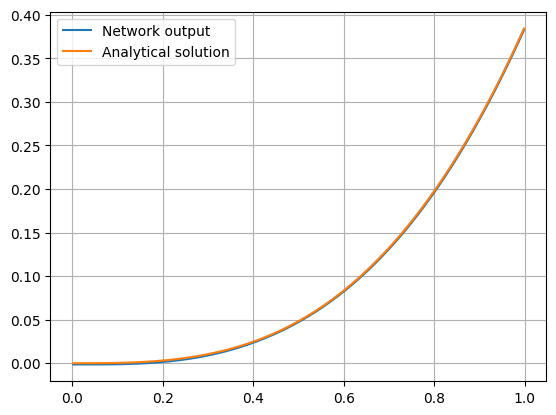

In [15]:
import matplotlib.pyplot as plt

k0 = 1.16
def f(t):
    return k0 * t**2

def F(t): # ground truth solution u_f
    return k0/3.0 * t**3

model.fix_branch_input(f)
grid_sampler = tp.samplers.GridSampler(T_int, 500)
grid_points = grid_sampler.sample_points().as_tensor
out = model(tp.spaces.Points(grid_points, T)).as_tensor.detach()[0]

grid_p = grid_points
plt.plot(grid_p, out)
plt.plot(grid_p, F(grid_p))
plt.grid()
plt.legend(['Network output', 'Analytical solution'])

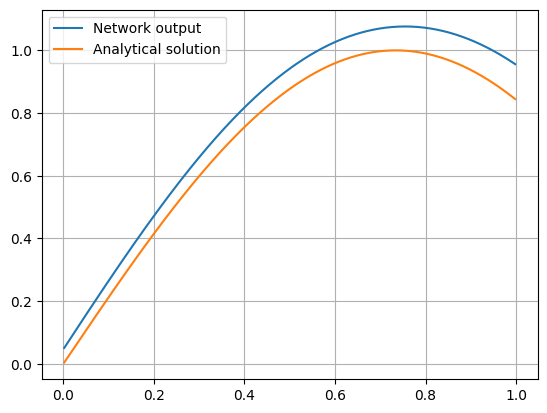

In [16]:
k0 = 2.14
def f(t):
    return k0 * torch.cos(k0*t)

def F(t): # ground truth solution u_f
    return torch.sin(k0*t)

model.fix_branch_input(f)
grid_sampler = tp.samplers.GridSampler(T_int, 500)
grid_points = grid_sampler.sample_points().as_tensor
out = model(tp.spaces.Points(grid_points, T)).as_tensor.detach()[0]

grid_p = grid_points
plt.plot(grid_p, out)
plt.plot(grid_p, F(grid_p))
plt.grid()
plt.legend(['Network output', 'Analytical solution'])